## Scrapowanie strony OTOMOTO

In [4]:
!python -m pip install --upgrade pip

In [5]:
!python -m pip install requests
!python -m pip install bs4
!python -m pip install lxml
!python -m pip install html5lib

In [6]:
import requests
from bs4 import BeautifulSoup
import time
import pandas as pd
import numpy as np

In [7]:
URL = "https://www.otomoto.pl/osobowe/audi/a3/od-2003?search%5Bfilter_enum_generation%5D=gen-8p-2003-2012&search%5Bfilter_float_year%3Ato%5D=2012"
zwrot_odpowiedz = requests.get(URL)
print(zwrot_odpowiedz)

<Response [200]>


In [8]:
html = zwrot_odpowiedz.content
zupa = BeautifulSoup(html, "html.parser")
#print(zupa)

In [9]:
# pobranie listy ofert na stronie
lista_aut = zupa.find_all("article", {"class": ["ooa-1g2kumr eayvfn60", "ooa-1rudse5 eayvfn60"]})
len(lista_aut)

32

In [10]:
#pobranie id oferty
id_oferty = lista_aut[1].get("id")
print(id_oferty)

#pobrania tytulu oferty
tytul_oferty = lista_aut[1].find("img").get("alt")
print(tytul_oferty)

tytul_oferty1 = lista_aut[1].find("h2", {"class": "eayvfn66 eayvfn620 ooa-10p8u4x er34gjf0"}).text.strip()
print(tytul_oferty1)

#pobrania linku oferty
link_oferty = lista_aut[1].find("a").get("href")
print(link_oferty)

6108884813
Audi A3 2.0 TDI Ambition
Audi A3 2.0 TDI Ambition
https://www.otomoto.pl/oferta/audi-a3-zadbany-ID6Fqg0d.html


In [11]:
#pobranie ceny i waluty
cena, s, oferta_waluta = lista_aut[0].find("span", {"class": "ooa-1bmnxg7 eayvfn611"}).text.strip().split(" ")
oferta_cena = int(cena + s)
print(oferta_cena)
print(oferta_waluta)

15900
PLN


In [12]:
lista_dod_inf = lista_aut[0].find_all("li", {"class": "ooa-1k7nwcr e19ivbs0"})
print(lista_dod_inf[0])

#rok
oferta_rocznik = int(lista_dod_inf[0].text)
print(oferta_rocznik)
#przebieg
oferta_przebieg = int(lista_dod_inf[1].text.strip("\nkm").replace(" ", ""))
print(oferta_przebieg)
#pojemnosc
oferta_pojenosc = int(lista_dod_inf[2].text.strip("\ncm3").replace(" ", ""))
print(oferta_pojenosc)
oferta_paliwo = lista_dod_inf[3].text
print(oferta_paliwo)

<li class="ooa-1k7nwcr e19ivbs0">2006</li>
2006
288027
1968
Diesel


In [13]:
oferta_miejscowosc = lista_aut[1].find("span", {"class": "ooa-fzu03x"}).text
print(oferta_miejscowosc)

Jeleń (Warmińsko-mazurskie)


In [14]:
#zdjecie
oferta_zdjecie_url = lista_aut[1].find("img").get("src")
print(oferta_zdjecie_url)

https://ireland.apollo.olxcdn.com/v1/files/eyJmbiI6Ink2d3FzbGNmOGNldDEtT1RPTU9UT1BMIiwidyI6W3siZm4iOiJ3ZzRnbnFwNnkxZi1PVE9NT1RPUEwiLCJzIjoiMTYiLCJwIjoiMTAsLTEwIiwiYSI6IjAifV19.LUP8jhtDYk1i3KN80Qzzmu2fgv1rExa-y8WCxKCFR0g/image;s=320x240


In [15]:
# pobranie liczby dostępnych stron w wyniku wyszukiwania
liczba_stron = zupa.find_all("a", {"class": "ooa-xdlax9 eesa4ha0"})[-1].text.strip()
print(liczba_stron)

40


## Pobieranie danych

In [16]:
def funkcja_pobrania_ofert_otomoto(marka="audi", model="a3", generacja="gen-8p-2003-2012", rok_od=2003, rok_do=2012):

  # tworzenie listy z nazwami cech
  wynik = [ ["url_baza",
             "url_strony",
             "n_strony",
             "id_oferty",
             "tytul_oferty",
             "link_oferty",
             "oferta_cena",
             "oferta_waluta",
             "oferta_miejscowosc",
             #"miniaturka_url",
             "oferta_rocznik",
             "oferta_przebieg",
             "oferta_pojemnosc",
             "oferta_paliwo"] ]

  # pobranie liczby dostępnych stron w wyniku wyszukiwania
  URL_baza = "https://www.otomoto.pl/osobowe/" + marka + "/" + str(model) + "/" + "od-" + str(rok_od) + "?search%5Bfilter_enum_generation%5D=" + str(generacja) + "&search%5Bfilter_float_year%3Ato%5D=" + str(rok_do)
  zadanie_url_baza = requests.get(URL_baza)
  html_url_baza = zadanie_url_baza.content
  zupa_url_baza = BeautifulSoup(html_url_baza, "html.parser")
  liczba_stron = int(zupa.find_all("a", {"class": "ooa-xdlax9 eesa4ha0"})[-1].text.strip())
  
  # pętla do pobrania wszystkich stron
  for n_strony in range(1, liczba_stron+1):
    time.sleep(2)
    # definiowanie żądania
    URL_strony = URL_baza + "&page=" + str(n_strony)
    zadanie_strona = requests.get(URL_strony) 
    print("Strona:", n_strony, "|", "Status:", zadanie_strona, sep=" ", end="\n")

    # pobranie strony html
    html_strony = zadanie_strona.content

    # tworzenie obiektu BeautifulSoup
    zupa_strony = BeautifulSoup(html_strony, "html.parser")

    # lista z informacjami o ofertach ze sparsowanej strony
    lista_aut = zupa_strony.find_all("article", {"class": ["ooa-1g2kumr eayvfn60", "ooa-1rudse5 eayvfn60"]})
    print("Lista ofert na stronie:", len(lista_aut), "| Strona: [", n_strony, "/", liczba_stron, "]", sep=" ", end="\n")

    for oferta in lista_aut:
      ## POBRANIE INFORMACJI - LISTA WYNIKÓW WYSZUKIWANIA
      
      id_oferty = oferta.get("id")

      tytul_oferty = oferta.find("h2", {"class": "eayvfn66 eayvfn620 ooa-10p8u4x er34gjf0"}).text.strip()

      link_oferty = oferta.find("a").get("href")

      #wykluczenie stron carsmile.pl i wyświetlenie linku oferty
      if "carsmile.pl" in link_oferty:
        continue

      cena, s, oferta_waluta = oferta.find("span", {"class": "ooa-1bmnxg7 eayvfn611"}).text.strip().split(" ")
      oferta_cena = int(cena + s)

      oferta_miejscowosc = oferta.find("span", {"class": "ooa-fzu03x"}).text

      #miniaturka_url = np.NaN if oferta.find("img").get("src")==None else oferta.find("img").get("src")

      ###
      lista_dod_inf = oferta.find_all("li", {"class": "ooa-1k7nwcr e19ivbs0"})
      if lista_dod_inf[0].text=='Niski przebieg':
        oferta_rocznik = lista_dod_inf[1].text
        oferta_przebieg = np.NaN if lista_dod_inf[2]==None else lista_dod_inf[2].text.strip("\nkm").replace(" ", "")
        oferta_pojemnosc = np.NaN if lista_dod_inf[3]==None else lista_dod_inf[3].text.strip("\ncm3").replace(" ", "")
        oferta_paliwo = lista_dod_inf[4].text
      else:
        oferta_rocznik = lista_dod_inf[0].text
        oferta_przebieg = np.NaN if lista_dod_inf[1]==None else lista_dod_inf[1].text.strip("\nkm").replace(" ", "")
        oferta_pojemnosc = np.NaN if lista_dod_inf[2]==None else lista_dod_inf[2].text.strip("\ncm3").replace(" ", "")
        oferta_paliwo = lista_dod_inf[3].text

      ## TWORZENIE ZBIORU DANYCH

      # tworzenie zbioru z wynikami
      wynik.append( [URL_baza, 
                    URL_strony, 
                    n_strony, 
                    id_oferty, 
                    tytul_oferty, 
                    link_oferty, 
                    oferta_cena, 
                    oferta_waluta,
                    oferta_miejscowosc,
                    #miniaturka_url,
                    oferta_rocznik, 
                    oferta_przebieg, 
                    oferta_pojemnosc, 
                    oferta_paliwo] )

  # przekształcenie zbioru danych w DF 
  return(pd.DataFrame(wynik[1:], columns=wynik[0]))

In [17]:
# przygotowanie df
dane_df = funkcja_pobrania_ofert_otomoto()

Strona: 1 | Status: <Response [200]>
Lista ofert na stronie: 32 | Strona: [ 1 / 40 ]
Strona: 2 | Status: <Response [200]>
Lista ofert na stronie: 32 | Strona: [ 2 / 40 ]
Strona: 3 | Status: <Response [200]>
Lista ofert na stronie: 32 | Strona: [ 3 / 40 ]
Strona: 4 | Status: <Response [200]>
Lista ofert na stronie: 31 | Strona: [ 4 / 40 ]
Strona: 5 | Status: <Response [200]>
Lista ofert na stronie: 32 | Strona: [ 5 / 40 ]
Strona: 6 | Status: <Response [200]>
Lista ofert na stronie: 32 | Strona: [ 6 / 40 ]
Strona: 7 | Status: <Response [200]>
Lista ofert na stronie: 32 | Strona: [ 7 / 40 ]
Strona: 8 | Status: <Response [200]>
Lista ofert na stronie: 32 | Strona: [ 8 / 40 ]
Strona: 9 | Status: <Response [200]>
Lista ofert na stronie: 32 | Strona: [ 9 / 40 ]
Strona: 10 | Status: <Response [200]>
Lista ofert na stronie: 32 | Strona: [ 10 / 40 ]
Strona: 11 | Status: <Response [200]>
Lista ofert na stronie: 32 | Strona: [ 11 / 40 ]
Strona: 12 | Status: <Response [200]>
Lista ofert na stronie:

In [18]:
# zapisywanie pliku z danymi
dane_df.to_csv("dane.csv", index=False)

In [19]:
# wczytanie danych
dane_df = pd.read_csv("dane.csv")
dane_df

,url_baza,url_strony,n_strony,id_oferty,tytul_oferty,link_oferty,oferta_cena,oferta_waluta,oferta_miejscowosc,oferta_rocznik,oferta_przebieg,oferta_pojemnosc,oferta_paliwo
0,https://www.otomoto.pl/osobowe/audi/a3/od-2003...,https://www.otomoto.pl/osobowe/audi/a3/od-2003...,1,6108663044,Audi A3,https://www.otomoto.pl/oferta/audi-a3-sprzedam...,15900,PLN,Tczew (Pomorskie),2006,288027,1968,Diesel
1,https://www.otomoto.pl/osobowe/audi/a3/od-2003...,https://www.otomoto.pl/osobowe/audi/a3/od-2003...,1,6108884813,Audi A3 2.0 TDI Ambition,https://www.otomoto.pl/oferta/audi-a3-zadbany-...,23000,PLN,Jeleń (Warmińsko-mazurskie),2008,248500,1968,Diesel
2,https://www.otomoto.pl/osobowe/audi/a3/od-2003...,https://www.otomoto.pl/osobowe/audi/a3/od-2003...,1,6108647944,Audi A3 1.9 TDI Ambition,https://www.otomoto.pl/oferta/audi-a3-1-9tdi-1...,26900,PLN,Zwoleń (Mazowieckie),2008,207000,1896,Diesel
3,https://www.otomoto.pl/osobowe/audi/a3/od-2003...,https://www.otomoto.pl/osobowe/audi/a3/od-2003...,1,6108643643,Audi A3 1.2 TFSI Ambition,https://www.otomoto.pl/oferta/audi-a3-nowy-roz...,26900,PLN,Poręba (Śląskie),2009,163502,1197,Benzyna
4,https://www.otomoto.pl/osobowe/audi/a3/od-2003...,https://www.otomoto.pl/osobowe/audi/a3/od-2003...,1,6108875733,Audi A3 2.0 TDI Sportback DPF quattro Ambition,https://www.otomoto.pl/oferta/audi-a3-2-kompl-...,37999,PLN,Kąty Opolskie (Opolskie),2011,211250,1968,Diesel
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1240,https://www.otomoto.pl/osobowe/audi/a3/od-2003...,https://www.otomoto.pl/osobowe/audi/a3/od-2003...,40,6108318499,Audi A3 1.6 TDI DPF Ambiente,https://www.otomoto.pl/oferta/audi-a3-audi-a3-...,28500,PLN,Tłuczań (Małopolskie),2010,178000,1598,Diesel
1241,https://www.otomoto.pl/osobowe/audi/a3/od-2003...,https://www.otomoto.pl/osobowe/audi/a3/od-2003...,40,6107174210,Audi A3,https://www.otomoto.pl/oferta/audi-a3-audi-a3-...,15900,PLN,Warszawa (Mazowieckie),2004,275000,1984,Benzyna
1242,https://www.otomoto.pl/osobowe/audi/a3/od-2003...,https://www.otomoto.pl/osobowe/audi/a3/od-2003...,40,6107780885,Audi A3 2.0 TDI DPF Prime Line S tronic,https://www.otomoto.pl/oferta/audi-a3-lift2-0-...,39900,PLN,Korzenna (Małopolskie),2012,217000,1968,Diesel
1243,https://www.otomoto.pl/osobowe/audi/a3/od-2003...,https://www.otomoto.pl/osobowe/audi/a3/od-2003...,40,6108265636,Audi A3 1.9 TDI Ambiente,https://www.otomoto.pl/oferta/audi-a3-audi-a3-...,14000,PLN,Wysoka (Wielkopolskie),2007,403000,1896,Diesel


## Analiza i przygotowanie danych

In [20]:
# import bibliotek
import pandas as pd
import numpy as np

In [21]:
# wczytanie danych
dane_df = pd.read_csv("dane.csv")
dane_df

,url_baza,url_strony,n_strony,id_oferty,tytul_oferty,link_oferty,oferta_cena,oferta_waluta,oferta_miejscowosc,oferta_rocznik,oferta_przebieg,oferta_pojemnosc,oferta_paliwo
0,https://www.otomoto.pl/osobowe/audi/a3/od-2003...,https://www.otomoto.pl/osobowe/audi/a3/od-2003...,1,6108663044,Audi A3,https://www.otomoto.pl/oferta/audi-a3-sprzedam...,15900,PLN,Tczew (Pomorskie),2006,288027,1968,Diesel
1,https://www.otomoto.pl/osobowe/audi/a3/od-2003...,https://www.otomoto.pl/osobowe/audi/a3/od-2003...,1,6108884813,Audi A3 2.0 TDI Ambition,https://www.otomoto.pl/oferta/audi-a3-zadbany-...,23000,PLN,Jeleń (Warmińsko-mazurskie),2008,248500,1968,Diesel
2,https://www.otomoto.pl/osobowe/audi/a3/od-2003...,https://www.otomoto.pl/osobowe/audi/a3/od-2003...,1,6108647944,Audi A3 1.9 TDI Ambition,https://www.otomoto.pl/oferta/audi-a3-1-9tdi-1...,26900,PLN,Zwoleń (Mazowieckie),2008,207000,1896,Diesel
3,https://www.otomoto.pl/osobowe/audi/a3/od-2003...,https://www.otomoto.pl/osobowe/audi/a3/od-2003...,1,6108643643,Audi A3 1.2 TFSI Ambition,https://www.otomoto.pl/oferta/audi-a3-nowy-roz...,26900,PLN,Poręba (Śląskie),2009,163502,1197,Benzyna
4,https://www.otomoto.pl/osobowe/audi/a3/od-2003...,https://www.otomoto.pl/osobowe/audi/a3/od-2003...,1,6108875733,Audi A3 2.0 TDI Sportback DPF quattro Ambition,https://www.otomoto.pl/oferta/audi-a3-2-kompl-...,37999,PLN,Kąty Opolskie (Opolskie),2011,211250,1968,Diesel
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1240,https://www.otomoto.pl/osobowe/audi/a3/od-2003...,https://www.otomoto.pl/osobowe/audi/a3/od-2003...,40,6108318499,Audi A3 1.6 TDI DPF Ambiente,https://www.otomoto.pl/oferta/audi-a3-audi-a3-...,28500,PLN,Tłuczań (Małopolskie),2010,178000,1598,Diesel
1241,https://www.otomoto.pl/osobowe/audi/a3/od-2003...,https://www.otomoto.pl/osobowe/audi/a3/od-2003...,40,6107174210,Audi A3,https://www.otomoto.pl/oferta/audi-a3-audi-a3-...,15900,PLN,Warszawa (Mazowieckie),2004,275000,1984,Benzyna
1242,https://www.otomoto.pl/osobowe/audi/a3/od-2003...,https://www.otomoto.pl/osobowe/audi/a3/od-2003...,40,6107780885,Audi A3 2.0 TDI DPF Prime Line S tronic,https://www.otomoto.pl/oferta/audi-a3-lift2-0-...,39900,PLN,Korzenna (Małopolskie),2012,217000,1968,Diesel
1243,https://www.otomoto.pl/osobowe/audi/a3/od-2003...,https://www.otomoto.pl/osobowe/audi/a3/od-2003...,40,6108265636,Audi A3 1.9 TDI Ambiente,https://www.otomoto.pl/oferta/audi-a3-audi-a3-...,14000,PLN,Wysoka (Wielkopolskie),2007,403000,1896,Diesel


In [22]:
dane_df[['oferta_miejscowosc', 'oferta_wojewodztwo']] = dane_df.oferta_miejscowosc.str.split("(", expand=True,)
dane_df['oferta_wojewodztwo'] = dane_df['oferta_wojewodztwo'].str.replace(")", "")
new_cols = ["url_baza","url_strony","n_strony","id_oferty","tytul_oferty","link_oferty","oferta_cena","oferta_waluta","oferta_miejscowosc","oferta_wojewodztwo","oferta_rocznik","oferta_przebieg","oferta_pojemnosc","oferta_paliwo"]
dane_df = dane_df[new_cols]

C:\Users\ict10\AppData\Local\Temp\ipykernel_23900\3252812382.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  dane_df['oferta_wojewodztwo'] = dane_df['oferta_wojewodztwo'].str.replace(")", "")


In [23]:
# rozmiar ramki danych
dane_df.shape

(1245, 14)

In [24]:
dane_df.describe()

,n_strony,id_oferty,oferta_cena,oferta_rocznik,oferta_przebieg,oferta_pojemnosc
count,1245.000000,1.245000e+03,1245.000000,1245.000000,1245.000000,1245.000000
mean,20.097992,6.107043e+09,23998.624096,2007.670683,228952.986345,1769.479518
std,11.326421,2.875831e+06,8099.924342,2.462089,56514.719050,257.376972
min,1.000000,6.060330e+09,1999.000000,2003.000000,51000.000000,189.000000
25%,10.000000,6.106921e+09,17900.000000,2006.000000,192580.000000,1598.000000
50%,20.000000,6.108043e+09,23900.000000,2008.000000,225000.000000,1896.000000
75%,30.000000,6.108464e+09,29900.000000,2009.000000,260000.000000,1968.000000
max,40.000000,6.108889e+09,55900.000000,2012.000000,510233.000000,2000.000000


In [25]:
dane_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1245 entries, 0 to 1244
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   url_baza            1245 non-null   object
 1   url_strony          1245 non-null   object
 2   n_strony            1245 non-null   int64 
 3   id_oferty           1245 non-null   int64 
 4   tytul_oferty        1245 non-null   object
 5   link_oferty         1245 non-null   object
 6   oferta_cena         1245 non-null   int64 
 7   oferta_waluta       1245 non-null   object
 8   oferta_miejscowosc  1245 non-null   object
 9   oferta_wojewodztwo  1245 non-null   object
 10  oferta_rocznik      1245 non-null   int64 
 11  oferta_przebieg     1245 non-null   int64 
 12  oferta_pojemnosc    1245 non-null   int64 
 13  oferta_paliwo       1245 non-null   object
dtypes: int64(6), object(8)
memory usage: 136.3+ KB


In [26]:
# liczba ofert wg. rocznika
dane_df["oferta_rocznik"].value_counts(dropna=False)

2009    200
2008    178
2007    146
2006    135
2005    129
2010    125
2011    111
2004     85
2012     70
2003     66
Name: oferta_rocznik, dtype: int64

In [27]:
# wstępna analiza
{
    "liczba pobranych ofert": dane_df.shape[0],
    "liczba unikalnych ID ofert": dane_df["id_oferty"].nunique(),
    "liczba zescrapowanych stron": dane_df["n_strony"].max(),
    "liczba unikalnych roczników produkcji": dane_df["oferta_rocznik"].nunique(),
    "typy paliwa": dane_df["oferta_paliwo"].unique(),
    "liczba unikalnych miejscowości": dane_df["oferta_miejscowosc"].nunique(),
    "wykorzystane waluty w ofertach": dane_df["oferta_waluta"].unique(),
    "średnia cena": dane_df["oferta_cena"].mean(),
    "minimalna cena": dane_df["oferta_cena"].min(),
    "maksymalna cena": dane_df["oferta_cena"].max()
}

{'liczba pobranych ofert': 1245,
 'liczba unikalnych ID ofert': 1244,
 'liczba zescrapowanych stron': 40,
 'liczba unikalnych roczników produkcji': 10,
 'typy paliwa': array(['Diesel', 'Benzyna', 'Benzyna+LPG'], dtype=object),
 'liczba unikalnych miejscowości': 569,
 'wykorzystane waluty w ofertach': array(['PLN', 'EUR'], dtype=object),
 'średnia cena': 23998.62409638554,
 'minimalna cena': 1999,
 'maksymalna cena': 55900}

In [28]:
# sprawdzenie liczności grupy oferta_wojewodztwo
dane_df["oferta_wojewodztwo"].value_counts()

Mazowieckie            181
Małopolskie            158
Śląskie                127
Dolnośląskie           127
Wielkopolskie          123
Pomorskie               78
Kujawsko-pomorskie      59
Świętokrzyskie          54
Łódzkie                 53
Lubelskie               52
Zachodniopomorskie      46
Warmińsko-mazurskie     44
Lubuskie                44
Podkarpackie            44
Opolskie                31
Podlaskie               24
Name: oferta_wojewodztwo, dtype: int64

In [29]:
# sprawdzenie liczności grupy z walutą EUR
dane_df["oferta_waluta"].value_counts()

PLN    1244
EUR       1
Name: oferta_waluta, dtype: int64

In [30]:
# usuwanie obserwacji z walutą EUR
dane_df_3 = dane_df[dane_df["oferta_waluta"]!="EUR"]
# ponowna analiza
{
    "wykorzystane waluty w ofertach": dane_df_3["oferta_waluta"].unique()
}

{'wykorzystane waluty w ofertach': array(['PLN'], dtype=object)}

In [31]:
# sprawdzenie liczby ofert wg. rodzaju paliwa
dane_df["oferta_paliwo"].value_counts()

Diesel         718
Benzyna        497
Benzyna+LPG     30
Name: oferta_paliwo, dtype: int64

In [32]:
# sprawdzenie liczby ofert wg. pojemności silnika
dane_df["oferta_pojemnosc"].value_counts(dropna=False)

1968    391
1896    200
1595    194
1598    169
1984     90
1798     70
1390     69
1197     18
1395     15
189      12
1600      7
1998      2
1900      2
2000      2
1400      2
1999      1
1958      1
Name: oferta_pojemnosc, dtype: int64

In [33]:
# podmiana ofert z pojemnością silnika "0" na modę
print("Moda: ", dane_df["oferta_pojemnosc"].mode())
moda = float(dane_df["oferta_pojemnosc"].mode().values)
dane_df["oferta_pojemnosc"] = dane_df["oferta_pojemnosc"].replace(0, moda)
# podmiana NaN na modę
dane_df["oferta_pojemnosc"] = dane_df["oferta_pojemnosc"].fillna(moda)
dane_df["oferta_pojemnosc"].value_counts(dropna=False)

Moda:  0    1968
Name: oferta_pojemnosc, dtype: int64


1968    391
1896    200
1595    194
1598    169
1984     90
1798     70
1390     69
1197     18
1395     15
189      12
1600      7
1998      2
1900      2
2000      2
1400      2
1999      1
1958      1
Name: oferta_pojemnosc, dtype: int64

In [34]:
# średnia cena auta wg. województwa
dane_df.groupby("oferta_wojewodztwo").agg(dict(oferta_cena = "mean")).sort_values(by = "oferta_cena", ascending = False)

,oferta_cena
oferta_wojewodztwo,
Mazowieckie,25562.143646
Opolskie,25374.032258
Podkarpackie,25307.863636
Podlaskie,24695.625000
Świętokrzyskie,24447.648148
Łódzkie,24247.301887
Małopolskie,24120.360759
Lubuskie,24054.863636
Lubelskie,23976.403846


In [35]:
# średnia cena auta wg. rocznika
dane_df.groupby("oferta_rocznik").agg(dict(oferta_cena = "mean")).sort_values(by = "oferta_cena", ascending = False)

,oferta_cena
oferta_rocznik,
2012,33532.842857
2011,32615.729730
2010,29838.520000
2009,28549.250000
2008,24984.168539
2007,20588.506849
2006,19287.755556
2005,17981.837209
2004,15079.176471


In [36]:
# średnia cena auta wg. rodzaju paliwa
dane_df.groupby("oferta_paliwo").agg(dict(oferta_cena = "mean")).sort_values(by = "oferta_cena", ascending = False)

,oferta_cena
oferta_paliwo,
Diesel,24880.906685
Benzyna,22858.973843
Benzyna+LPG,21762.866667


In [61]:
!python -m pip install ipykernel
#!python -m pip install nbformat

In [62]:
# analiza ceny wg. rodzaju paliwa i rocznika
import plotly.express as px

px.box(dane_df, 
       x = "oferta_rocznik", 
       y = "oferta_cena",
       color = "oferta_paliwo",
       title = "Cena samochodu z podziałem na rok produkcji oraz rodzaj paliwa")

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'alignmentgroup': 'True',
              'hovertemplate': 'oferta_paliwo=Diesel<br>oferta_rocznik=%{x}<br>oferta_cena=%{y}<extra></extra>',
              'legendgroup': 'Diesel',
              'marker': {'color': '#636efa'},
              'name': 'Diesel',
              'notched': False,
              'offsetgroup': 'Diesel',
              'orientation': 'v',
              'showlegend': True,
              'type': 'box',
              'x': array([2006, 2008, 2008, ..., 2012, 2007, 2005], dtype=int64),
              'x0': ' ',
              'xaxis': 'x',
              'y': array([15900, 23000, 26900, ..., 39900, 14000, 16800], dtype=int64),
              'y0': ' ',
              'yaxis': 'y'},
             {'alignmentgroup': 'True',
              'hovertemplate': 'oferta_paliwo=Benzyna<br>oferta_rocznik=%{x}<br>oferta_cena=%{y}<extra></extra>',
              'legendgroup': 'Benzyna',
              'marker': {'color': '#EF553B'},
              'name': 'Benzyna',
              'notched': False,
              'offsetgroup': 'Benzyna',
              'orientation': 'v',
              'showlegend': True,
              'type': 'box',
              'x': array([2009, 2011, 2006, ..., 2004, 2011, 2004], dtype=int64),
              'x0': ' ',
              'xaxis': 'x',
              'y': array([26900, 34900, 19900, ..., 12900, 27500, 15900], dtype=int64),
              'y0': ' ',
              'yaxis': 'y'},
             {'alignmentgroup': 'True',
              'hovertemplate': ('oferta_paliwo=Benzyna+LPG<br>o' ... 'ferta_cena=%{y}<extra></extra>'),
              'legendgroup': 'Benzyna+LPG',
              'marker': {'color': '#00cc96'},
              'name': 'Benzyna+LPG',
              'notched': False,
              'offsetgroup': 'Benzyna+LPG',
              'orientation': 'v',
              'showlegend': True,
              'type': 'box',
              'x': array([2012, 2004, 2008, 2003, 2005, 2007, 2004, 2007, 2009, 2007, 2009, 2004,
                          2004, 2005, 2003, 2009, 2004, 2008, 2006, 2009, 2005, 2009, 2006, 2003,
                          2004, 2005, 2007, 2003, 2005, 2003], dtype=int64),
              'x0': ' ',
              'xaxis': 'x',
              'y': array([38500, 28500, 19999, 16500, 22000, 18000, 32000, 18900, 32499, 21000,
                          24500,  2990, 16900, 35000, 12900, 32900, 25900, 19999, 23800, 34500,
                          18900, 23900, 17900, 14500,  8700, 24000, 26900, 10000, 17000, 13799],
                         dtype=int64),
              'y0': ' ',
              'yaxis': 'y'}],
    'layout': {'boxmode': 'group',
               'legend': {'title': {'text': 'oferta_paliwo'}, 'tracegroupgap': 0},
               'template': '...',
               'title': {'text': 'Cena samochodu z podziałem na rok produkcji oraz rodzaj paliwa'},
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'oferta_rocznik'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'oferta_cena'}}}
})

In [54]:
# analiza ceny wg. rocznika i województwa
import plotly.express as px

px.box(dane_df, 
       x = "oferta_wojewodztwo", 
       y = "oferta_cena",
       color = "oferta_rocznik",
       title = "Cena samochodu z podziałem na rocznik oraz województwo")

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'alignmentgroup': 'True',
              'hovertemplate': ('oferta_rocznik=2006<br>oferta_' ... 'ferta_cena=%{y}<extra></extra>'),
              'legendgroup': '2006',
              'marker': {'color': '#636efa'},
              'name': '2006',
              'notched': False,
              'offsetgroup': '2006',
              'orientation': 'v',
              'showlegend': True,
              'type': 'box',
              'x': array(['Pomorskie', 'Lubuskie', 'Małopolskie', 'Lubelskie', 'Pomorskie',
                          'Dolnośląskie', 'Dolnośląskie', 'Warmińsko-mazurskie', 'Lubelskie',
                          'Mazowieckie', 'Dolnośląskie', 'Warmińsko-mazurskie', 'Mazowieckie',
                          'Świętokrzyskie', 'Małopolskie', 'Łódzkie', 'Świętokrzyskie',
                          'Dolnośląskie', 'Śląskie', 'Podlaskie', 'Mazowieckie', 'Mazowieckie',
                          'Śląskie', 'Świętokrzyskie', 'Łódzkie', 'Warmińsko-mazurskie',
                          'Świętokrzyskie', 'Kujawsko-pomorskie', 'Małopolskie', 'Śląskie',
                          'Kujawsko-pomorskie', 'Śląskie', 'Małopolskie', 'Pomorskie',
                          'Dolnośląskie', 'Mazowieckie', 'Kujawsko-pomorskie', 'Wielkopolskie',
                          'Śląskie', 'Dolnośląskie', 'Świętokrzyskie', 'Pomorskie', 'Małopolskie',
                          'Kujawsko-pomorskie', 'Pomorskie', 'Kujawsko-pomorskie', 'Mazowieckie',
                          'Dolnośląskie', 'Małopolskie', 'Mazowieckie', 'Dolnośląskie',
                          'Kujawsko-pomorskie', 'Małopolskie', 'Mazowieckie', 'Mazowieckie',
                          'Wielkopolskie', 'Zachodniopomorskie', 'Pomorskie', 'Wielkopolskie',
                          'Dolnośląskie', 'Pomorskie', 'Kujawsko-pomorskie', 'Kujawsko-pomorskie',
                          'Podkarpackie', 'Zachodniopomorskie', 'Małopolskie', 'Małopolskie',
                          'Dolnośląskie', 'Wielkopolskie', 'Śląskie', 'Małopolskie',
                          'Mazowieckie', 'Pomorskie', 'Dolnośląskie', 'Warmińsko-mazurskie',
                          'Lubuskie', 'Małopolskie', 'Małopolskie', 'Warmińsko-mazurskie',
                          'Dolnośląskie', 'Warmińsko-mazurskie', 'Kujawsko-pomorskie',
                          'Kujawsko-pomorskie', 'Dolnośląskie', 'Podkarpackie', 'Dolnośląskie',
                          'Mazowieckie', 'Pomorskie', 'Zachodniopomorskie', 'Lubuskie',
                          'Wielkopolskie', 'Kujawsko-pomorskie', 'Małopolskie', 'Łódzkie',
                          'Świętokrzyskie', 'Pomorskie', 'Lubelskie', 'Lubuskie', 'Wielkopolskie',
                          'Warmińsko-mazurskie', 'Śląskie', 'Dolnośląskie', 'Opolskie',
                          'Opolskie', 'Podlaskie', 'Podkarpackie', 'Śląskie', 'Śląskie',
                          'Lubelskie', 'Zachodniopomorskie', 'Dolnośląskie', 'Wielkopolskie',
                          'Pomorskie', 'Wielkopolskie', 'Wielkopolskie', 'Zachodniopomorskie',
                          'Łódzkie', 'Świętokrzyskie', 'Zachodniopomorskie', 'Mazowieckie',
                          'Małopolskie', 'Pomorskie', 'Mazowieckie', 'Mazowieckie', 'Opolskie',
                          'Małopolskie', 'Dolnośląskie', 'Śląskie', 'Kujawsko-pomorskie',
                          'Wielkopolskie', 'Dolnośląskie', 'Podkarpackie', 'Podkarpackie',
                          'Wielkopolskie', 'Dolnośląskie'], dtype=object),
              'x0': ' ',
              'xaxis': 'x',
              'y': array([15900, 19900, 22000, 22500, 16999, 24500, 19500, 19999, 16000, 22900,
                          21900, 18500, 23900, 19900, 17900, 22000, 16900, 20700, 16999,  9900,
                          22900, 15900, 18500, 15777, 24999, 20900, 19900, 18900, 22900, 17500,
                          16500, 18900, 19500, 26900, 23900, 19900, 13990, 17900, 18700, 24900,
                          21500, 19900, 22950, 17800, 16900, 23900, 19700, 25900, 20999, 20900,


In [ ]:
# cena auta z podziałem na rodzaj paliwa i rocznik
px.box(dane_df, 
       x = "oferta_paliwo", 
       y = "oferta_cena", 
       notched = True, 
       facet_col = "oferta_rocznik",
       title = "Cena samochodu z podziałem na rodzaj paliwa i rocznik") 

In [ ]:
# analiza ofert pod kątem ceny, przebiegu oraz rodzaju paliwa
px.histogram(dane_df, 
             x = "oferta_przebieg", 
             y= "oferta_cena", 
             color = "oferta_paliwo",
             marginal = "violin")

In [ ]:
# sprawdzenie zależności miedzy ceną auta, przebiegiem, rocznikiem i rodzajem paliwa
px.scatter(dane_df, 
           x = "oferta_przebieg", 
           y = "oferta_rocznik", 
           color = "oferta_paliwo",
           size = "oferta_cena")

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



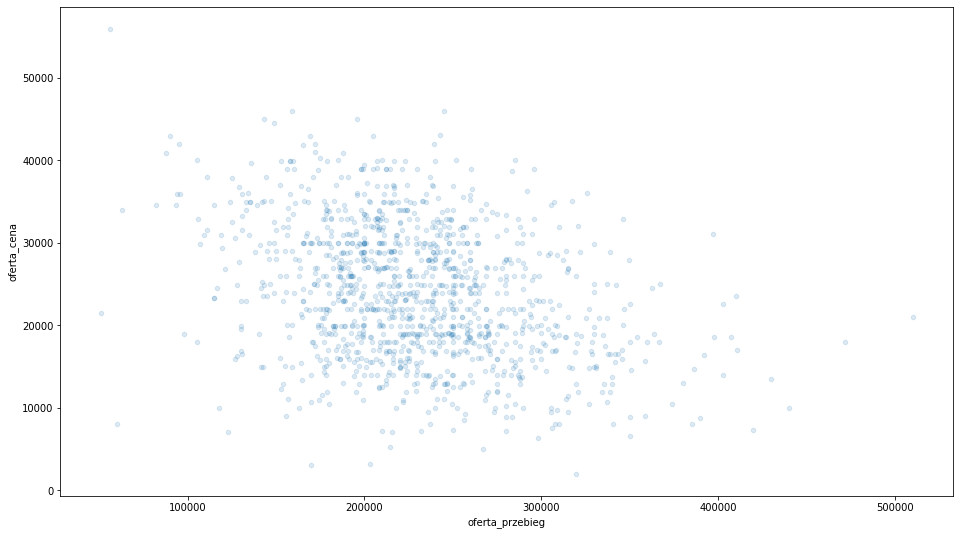

In [ ]:
# wizualizacja pokazująca większą koncentrację wartośći w zależności ceny a przebiegu
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams["figure.figsize"] = (16,9)
import seaborn as sns

dane_df.plot(kind = "scatter", 
               x = "oferta_przebieg",
               y = "oferta_cena",
               alpha = .15);

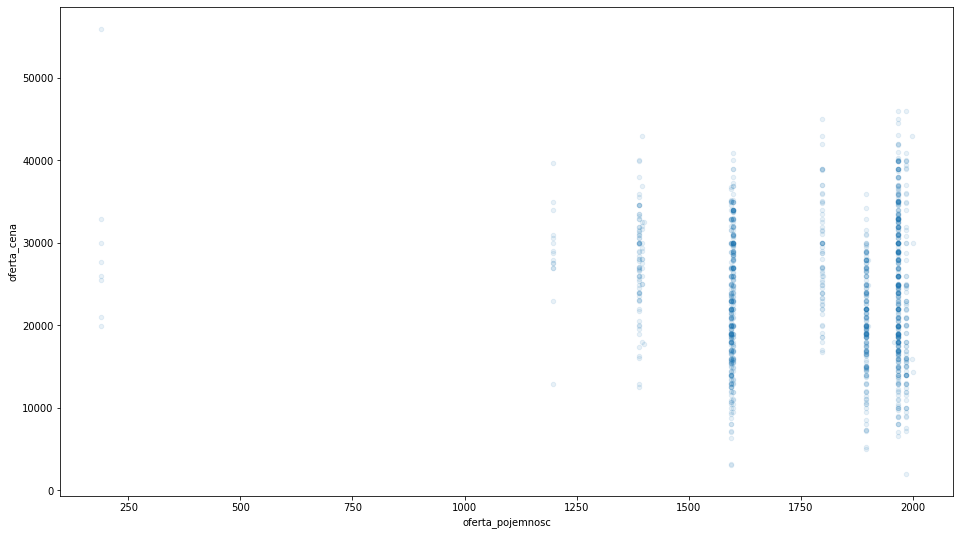

In [ ]:
# wizualizacja pokazująca większą koncentrację wartośći w zależności ceny a pojemności silnika
dane_df.plot(kind = "scatter", 
               x = "oferta_pojemnosc",
               y = "oferta_cena",
               alpha = .1);

In [ ]:
# zapisywanie pliku z danymi
dane_df.to_csv("dane_df.csv", index=False)

## Przygotowanie zbioru danych do modelowania

In [ ]:
# wczytanie danych
dane_df_3 = pd.read_csv("dane_df.csv")
dane_df_3

,url_baza,url_strony,n_strony,id_oferty,tytul_oferty,link_oferty,oferta_cena,oferta_waluta,oferta_miejscowosc,oferta_wojewodztwo,oferta_rocznik,oferta_przebieg,oferta_pojemnosc,oferta_paliwo
0,https://www.otomoto.pl/osobowe/mazda/3/od-2013...,https://www.otomoto.pl/osobowe/mazda/3/od-2013...,1,6107063818,Mazda 3,https://www.otomoto.pl/oferta/mazda-3-sprzedam...,56900,PLN,Warszawa,Mazowieckie,2017,145288,1998,Benzyna
1,https://www.otomoto.pl/osobowe/mazda/3/od-2013...,https://www.otomoto.pl/osobowe/mazda/3/od-2013...,1,6108503807,Mazda 3 2.0 Skymotion,https://www.otomoto.pl/oferta/mazda-3-2-0-mazd...,55000,PLN,Kozienice,Mazowieckie,2014,85600,1998,Benzyna
2,https://www.otomoto.pl/osobowe/mazda/3/od-2013...,https://www.otomoto.pl/osobowe/mazda/3/od-2013...,1,6108300022,Mazda 3 1.5 Skymotion,https://www.otomoto.pl/oferta/mazda-3-mazda-3-...,41000,PLN,Bydgoszcz,Kujawsko-pomorskie,2013,124530,1496,Benzyna
3,https://www.otomoto.pl/osobowe/mazda/3/od-2013...,https://www.otomoto.pl/osobowe/mazda/3/od-2013...,1,6107117090,Mazda 3 2.0 Skymotion,https://www.otomoto.pl/oferta/mazda-3-120km-na...,57900,PLN,Bielawa,Dolnośląskie,2017,58000,1998,Benzyna
4,https://www.otomoto.pl/osobowe/mazda/3/od-2013...,https://www.otomoto.pl/osobowe/mazda/3/od-2013...,1,6103937778,Mazda 3 2.0 Skypassion,https://www.otomoto.pl/oferta/mazda-3-mazda-3-...,55500,PLN,Łódź,Łódzkie,2015,91500,1998,Benzyna
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,https://www.otomoto.pl/osobowe/mazda/3/od-2013...,https://www.otomoto.pl/osobowe/mazda/3/od-2013...,8,6106451404,Mazda 3,https://www.otomoto.pl/oferta/mazda-3-mazda-3-...,57900,PLN,Warszawa,Mazowieckie,2017,127587,1998,Benzyna
245,https://www.otomoto.pl/osobowe/mazda/3/od-2013...,https://www.otomoto.pl/osobowe/mazda/3/od-2013...,8,6108081370,Mazda 3 2.0 Skymotion,https://www.otomoto.pl/oferta/mazda-3-pierwszy...,34000,PLN,Kraków,Małopolskie,2015,110232,1998,Benzyna
246,https://www.otomoto.pl/osobowe/mazda/3/od-2013...,https://www.otomoto.pl/osobowe/mazda/3/od-2013...,8,6108049112,Mazda 3 2.0 Skymotion,https://www.otomoto.pl/oferta/mazda-3-mazda-sa...,61900,PLN,Kórnik,Wielkopolskie,2016,125000,1998,Benzyna
247,https://www.otomoto.pl/osobowe/mazda/3/od-2013...,https://www.otomoto.pl/osobowe/mazda/3/od-2013...,8,6106274681,Mazda 3 SKYACTIV-D 150 Automatik Sports-Line,https://www.otomoto.pl/oferta/mazda-3-2-2d-150...,29900,PLN,Nowy Targ,Małopolskie,2014,137000,2191,Diesel


In [ ]:
# definiowanie cech do modelowania
cechy_do_modelowania = ["oferta_cena", "oferta_rocznik", "oferta_przebieg", "oferta_paliwo", "oferta_pojemnosc"]
dane_modelowanie = dane_df_3[cechy_do_modelowania]
dane_modelowanie

,oferta_cena,oferta_rocznik,oferta_przebieg,oferta_paliwo,oferta_pojemnosc
0,56900,2017,145288,Benzyna,1998
1,55000,2014,85600,Benzyna,1998
2,41000,2013,124530,Benzyna,1496
3,57900,2017,58000,Benzyna,1998
4,55500,2015,91500,Benzyna,1998
...,...,...,...,...,...
244,57900,2017,127587,Benzyna,1998
245,34000,2015,110232,Benzyna,1998
246,61900,2016,125000,Benzyna,1998
247,29900,2014,137000,Diesel,2191


In [ ]:
dane_modelowanie.describe()

,oferta_cena,oferta_rocznik,oferta_przebieg,oferta_pojemnosc
count,249.000000,249.000000,249.000000,249.000000
mean,54265.787149,2015.638554,117113.891566,1965.244980
std,11759.856857,1.480341,53094.144276,187.825975
min,11100.000000,2013.000000,10563.000000,1496.000000
25%,47900.000000,2014.000000,79500.000000,1998.000000
50%,53900.000000,2016.000000,110232.000000,1998.000000
75%,62000.000000,2017.000000,148858.000000,1998.000000
max,94000.000000,2019.000000,343498.000000,2488.000000


In [ ]:
dane_modelowanie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   oferta_cena       249 non-null    int64 
 1   oferta_rocznik    249 non-null    int64 
 2   oferta_przebieg   249 non-null    int64 
 3   oferta_paliwo     249 non-null    object
 4   oferta_pojemnosc  249 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 9.9+ KB


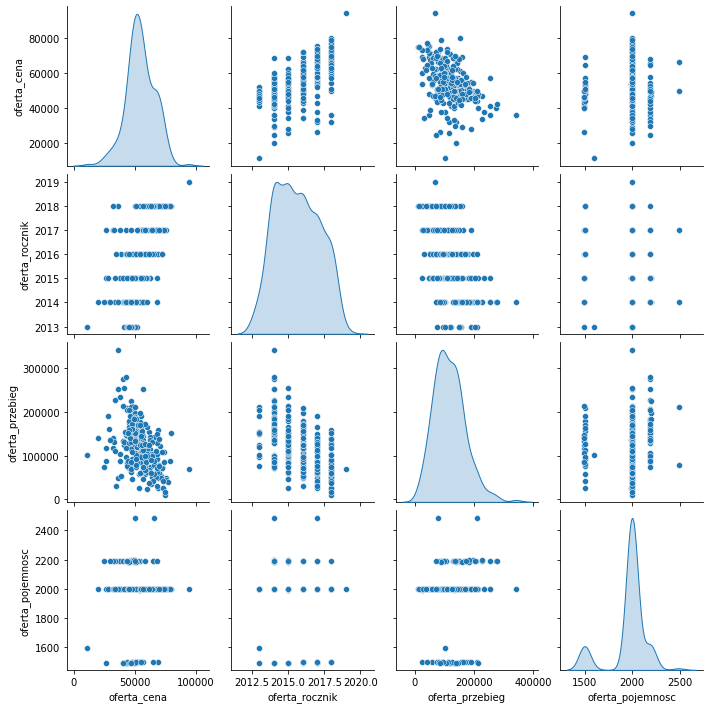

In [ ]:
# wykres zależności między cechami
sns.pairplot(dane_modelowanie, diag_kind="kde");

In [ ]:
# wartości odstające wg. cech numerycznych
px.box(dane_modelowanie, x = "oferta_cena", title = "Rozrzut cechy - oferta_cena", orientation = "h")

In [ ]:
px.box(dane_modelowanie, x = "oferta_przebieg", title = "Rozrzut cechy - oferta_przebieg", orientation = "h")

In [ ]:
px.box(dane_modelowanie, x = "oferta_pojemnosc", title = "Rozrzut cechy - oferta_przebieg", orientation = "h")

#### Usuwanie wartości odstających

In [ ]:
#rozmiar ramki danych
dane_modelowanie.shape

(249, 5)

##### Pojemność silnika 

In [ ]:
# więcej informacji o pojemności silnika mocno odstającej
#dane_modelowanie[dane_modelowanie["oferta_pojemnosc"]==1599]

In [ ]:
# tworzenie funkcji do identyfikacji anomalii (Q1~10%, Q3~90%)
def IQR_outliers(a):
  Q1, Q3 = np.percentile(a, [10, 90])
  IQR = Q3 - Q1

  gorne_ograniczenie  = Q3 + (1.5 * IQR)
  dolne_ograniczenie  = Q1 - (1.5 * IQR)
  print("Górne ograniczenie:", gorne_ograniczenie)
  print("Dolne ograniczenie:", dolne_ograniczenie)

  indeksy = np.where((a > gorne_ograniczenie) | (a < dolne_ograniczenie))
  b = np.full(shape=a.shape[0], fill_value=1)
  b[indeksy] = -1
  
  return b

# użycie funkcji
dane_modelowanie["flaga_IQR"] = IQR_outliers(dane_modelowanie["oferta_pojemnosc"])
print(dane_modelowanie["flaga_IQR"])

# wizualizacja wartości odstających wg. pojemności silnika
px.scatter(dane_modelowanie, 
           x = "oferta_cena", 
           y = "oferta_pojemnosc",
           hover_name = "oferta_rocznik",
           color = "flaga_IQR", 
           title = "Rozrzut cechy - oferta_pojemność a wartości odstające")

Górne ograniczenie: 3229.0
Dolne ograniczenie: 461.0
0      1
1      1
2      1
3      1
4      1
      ..
244    1
245    1
246    1
247    1
248    1
Name: flaga_IQR, Length: 249, dtype: int64


<ipython-input-57-b3243f4b236e>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# usuwanie obserwacji odstajacych wg. pojemności silnika
dane_modelowanie_2 = dane_modelowanie[dane_modelowanie["flaga_IQR"]==1]
dane_modelowanie_2.shape

(249, 6)

##### Przebieg samochodu

In [ ]:
# tworzenie funkcji do identyfikacji anomalii (Q1~25%, Q3~75%)
def IQR_outliers_2(a):
  Q1, Q3 = np.percentile(a, [30, 70])
  IQR = Q3 - Q1

  gorne_ograniczenie  = Q3 + (2.1 * IQR)
  dolne_ograniczenie  = Q1 - (2.0 * IQR)
  print("Górne ograniczenie:", gorne_ograniczenie)
  print("Dolne ograniczenie:", dolne_ograniczenie)

  indeksy = np.where((a > gorne_ograniczenie) | (a < dolne_ograniczenie))
  b = np.full(shape=a.shape[0], fill_value=1)
  b[indeksy] = -1
  
  return b

In [ ]:
# użycie funkcji
dane_modelowanie_2["flaga_IQR"] = IQR_outliers_2(dane_modelowanie_2["oferta_przebieg"])
print(dane_modelowanie_2["flaga_IQR"])

# wizualizacja wartości odstających wg. przebiegu samochodu
px.scatter(dane_modelowanie_2, 
           x = "oferta_cena", 
           y = "oferta_przebieg",
           hover_name = "oferta_rocznik",
           color = "flaga_IQR", 
           title = "Rozrzut cechy - oferta_przebieg a wartości odstające")

Górne ograniczenie: 256856.0
Dolne ograniczenie: -25480.0
0      1
1      1
2      1
3      1
4      1
      ..
244    1
245    1
246    1
247    1
248    1
Name: flaga_IQR, Length: 249, dtype: int64


In [ ]:
# usuwanie obserwacji odstajacych wg. przebiegu samochodu
dane_modelowanie_3 = dane_modelowanie_2[dane_modelowanie_2["flaga_IQR"]==1]
dane_modelowanie_3.shape

(246, 6)

##### Cena samochodu

In [ ]:
# tworzenie funkcji do identyfikacji anomalii (Q1~25%, Q3~75%)
def IQR_outliers_3(a):
  Q1, Q3 = np.percentile(a, [25, 75])
  IQR = Q3 - Q1

  gorne_ograniczenie  = Q3 + (4.0 * IQR)
  dolne_ograniczenie  = Q1 - (1.0 * IQR)
  print("Górne ograniczenie:", gorne_ograniczenie)
  print("Dolne ograniczenie:", dolne_ograniczenie)

  indeksy = np.where((a > gorne_ograniczenie) | (a < dolne_ograniczenie))
  b = np.full(shape=a.shape[0], fill_value=1)
  b[indeksy] = -1
  
  return b

In [ ]:
# użycie funkcji
dane_modelowanie_3["flaga_IQR"] = IQR_outliers_3(dane_modelowanie_3["oferta_cena"])
print(dane_modelowanie_3["flaga_IQR"])

# wizualizacja wartości odstających wg. ceny samochodu
px.scatter(dane_modelowanie_3, 
           x = "oferta_przebieg", 
           y = "oferta_cena",
           hover_name = "oferta_rocznik",
           color = "flaga_IQR", 
           title = "Rozrzut cechy - oferta_cena a wartości odstające")

Górne ograniczenie: 118400.0
Dolne ograniczenie: 33800.0
0      1
1      1
2      1
3      1
4      1
      ..
244    1
245    1
246    1
247   -1
248    1
Name: flaga_IQR, Length: 246, dtype: int64


<ipython-input-63-8a36438d50e9>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# usuwanie obserwacji odstajacych wg. ceny samochodu
dane_modelowanie_4 = dane_modelowanie_3[dane_modelowanie_3["flaga_IQR"]==1]
dane_modelowanie_4.shape

(235, 6)

In [ ]:
# oblicznie % usuniętych obserwacji
print("% usuniętych obserwacji odstających: ", ((dane_df_3.shape[0]-dane_modelowanie_4.shape[0])/dane_df_3.shape[0])*100)

% usuniętych obserwacji odstających:  5.622489959839357


In [ ]:
# usuwanie nieużuwanej cechy - flaga_IQR
dane_modelowanie_4.drop(columns = ["flaga_IQR"], inplace = True)
dane_modelowanie_4

<ipython-input-66-11b0b008faa5>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,oferta_cena,oferta_rocznik,oferta_przebieg,oferta_paliwo,oferta_pojemnosc
0,56900,2017,145288,Benzyna,1998
1,55000,2014,85600,Benzyna,1998
2,41000,2013,124530,Benzyna,1496
3,57900,2017,58000,Benzyna,1998
4,55500,2015,91500,Benzyna,1998
...,...,...,...,...,...
242,55000,2015,144000,Benzyna,1998
244,57900,2017,127587,Benzyna,1998
245,34000,2015,110232,Benzyna,1998
246,61900,2016,125000,Benzyna,1998


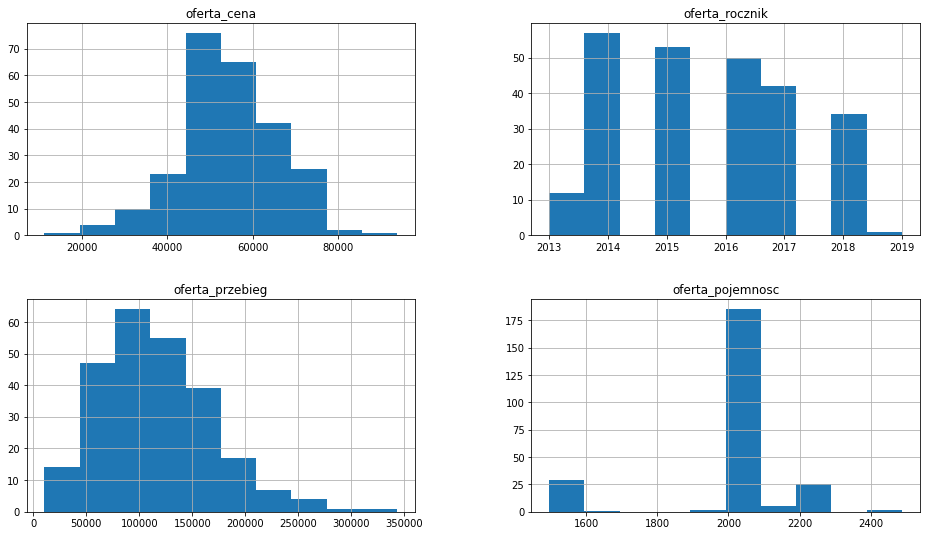

In [ ]:
# rozkład przed usunięciem wartości odstających
dane_modelowanie.drop(columns=["flaga_IQR"]).hist(bins=10);

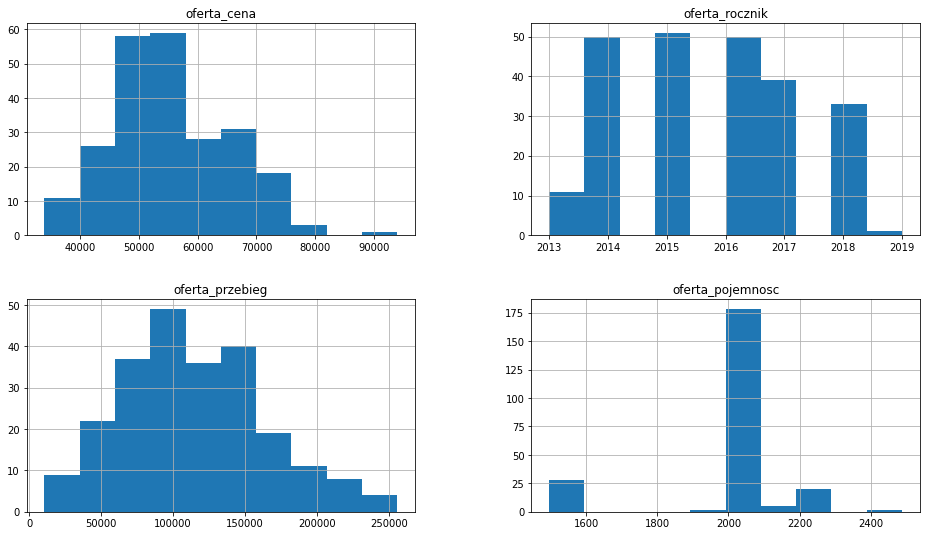

In [ ]:
# rozkład po usunięciu wartości odstających
dane_modelowanie_4.hist(bins=10);

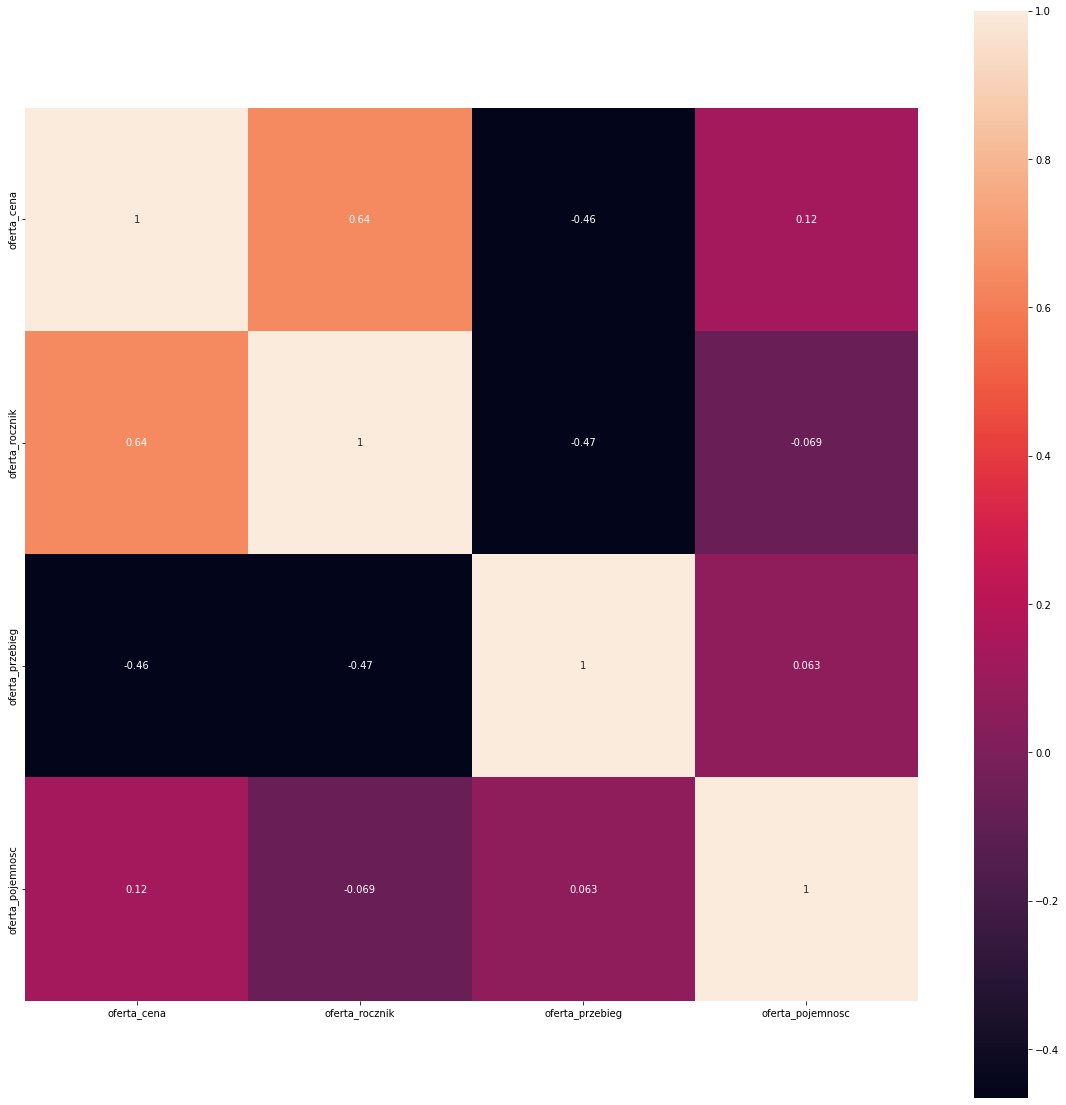

In [ ]:
# sprawdzenie korelacji między zmiennymi
korelacja = dane_modelowanie_4.corr()
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(korelacja, square = True, annot = True);

#### Kodowanie kategorii i tworzenie nowych zmiennych

Uwaga: warto uważać przy uzyciu `get_dummies()`, ponieważ jeśli pojawi się nowa kategoria w danych to wtedy stworzymy dla niej osobną kolumnę. A to oznacza, że liczba oraz nazwa kolumn może się nie zgadzać z naszą strukturą w wyuczonym modelu. W takich przypadkach najlepiej używać `OneHotEncoder()`, podając argument `handle_unknown="ignore"`, co pozwoli pominąć nową kategorię przy kodowaniu kategorii.

In [ ]:
# liczość grupy 
dane_modelowanie_4["oferta_paliwo"].value_counts()

Benzyna        192
Diesel          42
Benzyna+LPG      1
Name: oferta_paliwo, dtype: int64

In [ ]:
# usuwanie mało reprezentatywnej kategorii Benzyna+LPG
#dane_modelowanie_5 = dane_modelowanie_4[dane_modelowanie_4["oferta_paliwo"]!="Benzyna+LPG"]
#dane_modelowanie_5["oferta_paliwo"].value_counts()

# jeżeli nie usuwamy mało licznej klasy
dane_modelowanie_5 = dane_modelowanie_4

In [ ]:
import datetime

# dodanie zmiennej wiek samochodu na podstawie zmiennej przedziałowej oferta_rocznik
dane_modelowanie_5["oferta_wiek"] = datetime.datetime.now().year - dane_modelowanie_5["oferta_rocznik"]
dane_modelowanie_5

<ipython-input-72-65293a62b82f>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,oferta_cena,oferta_rocznik,oferta_przebieg,oferta_paliwo,oferta_pojemnosc,oferta_wiek
0,56900,2017,145288,Benzyna,1998,6
1,55000,2014,85600,Benzyna,1998,9
2,41000,2013,124530,Benzyna,1496,10
3,57900,2017,58000,Benzyna,1998,6
4,55500,2015,91500,Benzyna,1998,8
...,...,...,...,...,...,...
242,55000,2015,144000,Benzyna,1998,8
244,57900,2017,127587,Benzyna,1998,6
245,34000,2015,110232,Benzyna,1998,8
246,61900,2016,125000,Benzyna,1998,7


In [ ]:
# tworzenie 3 kategorii na podstawie zakresu lat produkcji aut 
# (mean-odch.std, mean, mean+odch.std)
lista_rocznikow = dane_modelowanie_5["oferta_rocznik"].unique().tolist()
print("Lista roczników: ", lista_rocznikow)
print("Średnia z rocznika:", int(np.mean(lista_rocznikow)), "oraz odchylenie standardowe rocznika:", int(np.std(lista_rocznikow)), sep=" ", end="\n")
zakresy_lat_produkcji = np.digitize(dane_modelowanie_5["oferta_rocznik"], 
                                    bins=[int(np.mean(lista_rocznikow) - np.std(lista_rocznikow)),
                                          int(np.mean(lista_rocznikow)), 
                                          int(np.mean(lista_rocznikow) + np.std(lista_rocznikow))])
# dodanie kategorii
dane_modelowanie_5["zakresy_lat_produkcji"] = zakresy_lat_produkcji

Lista roczników:  [2017, 2014, 2013, 2015, 2016, 2018, 2019]
Średnia z rocznika: 2016 oraz odchylenie standardowe rocznika: 2


<ipython-input-73-ee8b63985578>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
np.unique(zakresy_lat_produkcji)

array([0, 1, 2, 3])

In [ ]:
# usuwanie rocznik ze zbioru danych
dane_modelowanie_5.drop(columns=["oferta_rocznik"], inplace=True)
dane_modelowanie_5

<ipython-input-75-8c1df031ddb6>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,oferta_cena,oferta_przebieg,oferta_paliwo,oferta_pojemnosc,oferta_wiek,zakresy_lat_produkcji
0,56900,145288,Benzyna,1998,6,2
1,55000,85600,Benzyna,1998,9,1
2,41000,124530,Benzyna,1496,10,0
3,57900,58000,Benzyna,1998,6,2
4,55500,91500,Benzyna,1998,8,1
...,...,...,...,...,...,...
242,55000,144000,Benzyna,1998,8,1
244,57900,127587,Benzyna,1998,6,2
245,34000,110232,Benzyna,1998,8,1
246,61900,125000,Benzyna,1998,7,2


In [ ]:
# kodowanie kategorii dotyczacej paliwa
dane_modelowanie_6 = pd.get_dummies(dane_modelowanie_5, columns=["oferta_paliwo", "zakresy_lat_produkcji"], prefix_sep="_")
dane_modelowanie_6

,oferta_cena,oferta_przebieg,oferta_pojemnosc,oferta_wiek,oferta_paliwo_Benzyna,oferta_paliwo_Benzyna+LPG,oferta_paliwo_Diesel,zakresy_lat_produkcji_0,zakresy_lat_produkcji_1,zakresy_lat_produkcji_2,zakresy_lat_produkcji_3
0,56900,145288,1998,6,1,0,0,0,0,1,0
1,55000,85600,1998,9,1,0,0,0,1,0,0
2,41000,124530,1496,10,1,0,0,1,0,0,0
3,57900,58000,1998,6,1,0,0,0,0,1,0
4,55500,91500,1998,8,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
242,55000,144000,1998,8,1,0,0,0,1,0,0
244,57900,127587,1998,6,1,0,0,0,0,1,0
245,34000,110232,1998,8,1,0,0,0,1,0,0
246,61900,125000,1998,7,1,0,0,0,0,1,0


#### Sprawdzenie korelacji

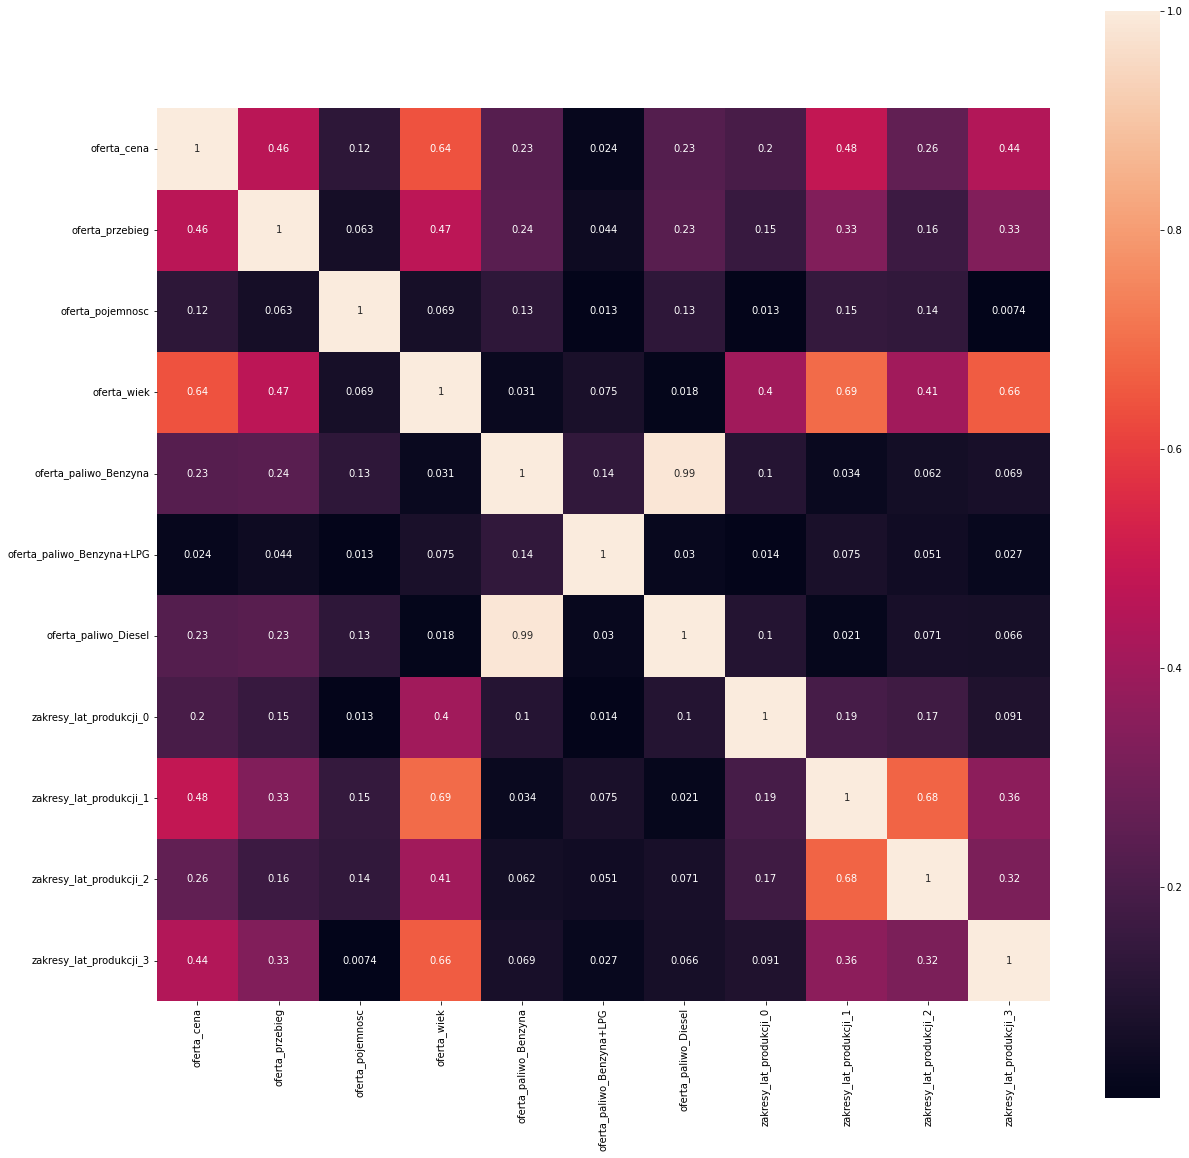

In [ ]:
# sprawdzenie korelacji między zmiennymi - całkowita
korelacja = dane_modelowanie_6.corr().abs()
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(korelacja, square = True, annot = True);

In [ ]:
# zdefiniowanie macierzy do filtrowania
macierz_filter = np.triu(np.ones(korelacja.shape), k=1).astype(np.bool)

# wybranie górnej części trójkąta w macierzy korelacji
gorny_trojkat = korelacja.where(macierz_filter)

# zdefiniowanie indeksów kolumn o korelacji powyżej 0.9
indeks_mocna_korelacja = [kolumna for kolumna in gorny_trojkat.columns if any(gorny_trojkat[kolumna] > 0.9)]
print(indeks_mocna_korelacja)

['oferta_paliwo_Diesel']


<ipython-input-78-7c9d54049e30>:2: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



In [ ]:
# usuwanie silnie zaleźnych zmiennych >0.9
dane_modelowanie_6.drop(columns=indeks_mocna_korelacja, inplace=True)
dane_modelowanie_6

,oferta_cena,oferta_przebieg,oferta_pojemnosc,oferta_wiek,oferta_paliwo_Benzyna,oferta_paliwo_Benzyna+LPG,zakresy_lat_produkcji_0,zakresy_lat_produkcji_1,zakresy_lat_produkcji_2,zakresy_lat_produkcji_3
0,56900,145288,1998,6,1,0,0,0,1,0
1,55000,85600,1998,9,1,0,0,1,0,0
2,41000,124530,1496,10,1,0,1,0,0,0
3,57900,58000,1998,6,1,0,0,0,1,0
4,55500,91500,1998,8,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
242,55000,144000,1998,8,1,0,0,1,0,0
244,57900,127587,1998,6,1,0,0,0,1,0
245,34000,110232,1998,8,1,0,0,1,0,0
246,61900,125000,1998,7,1,0,0,0,1,0


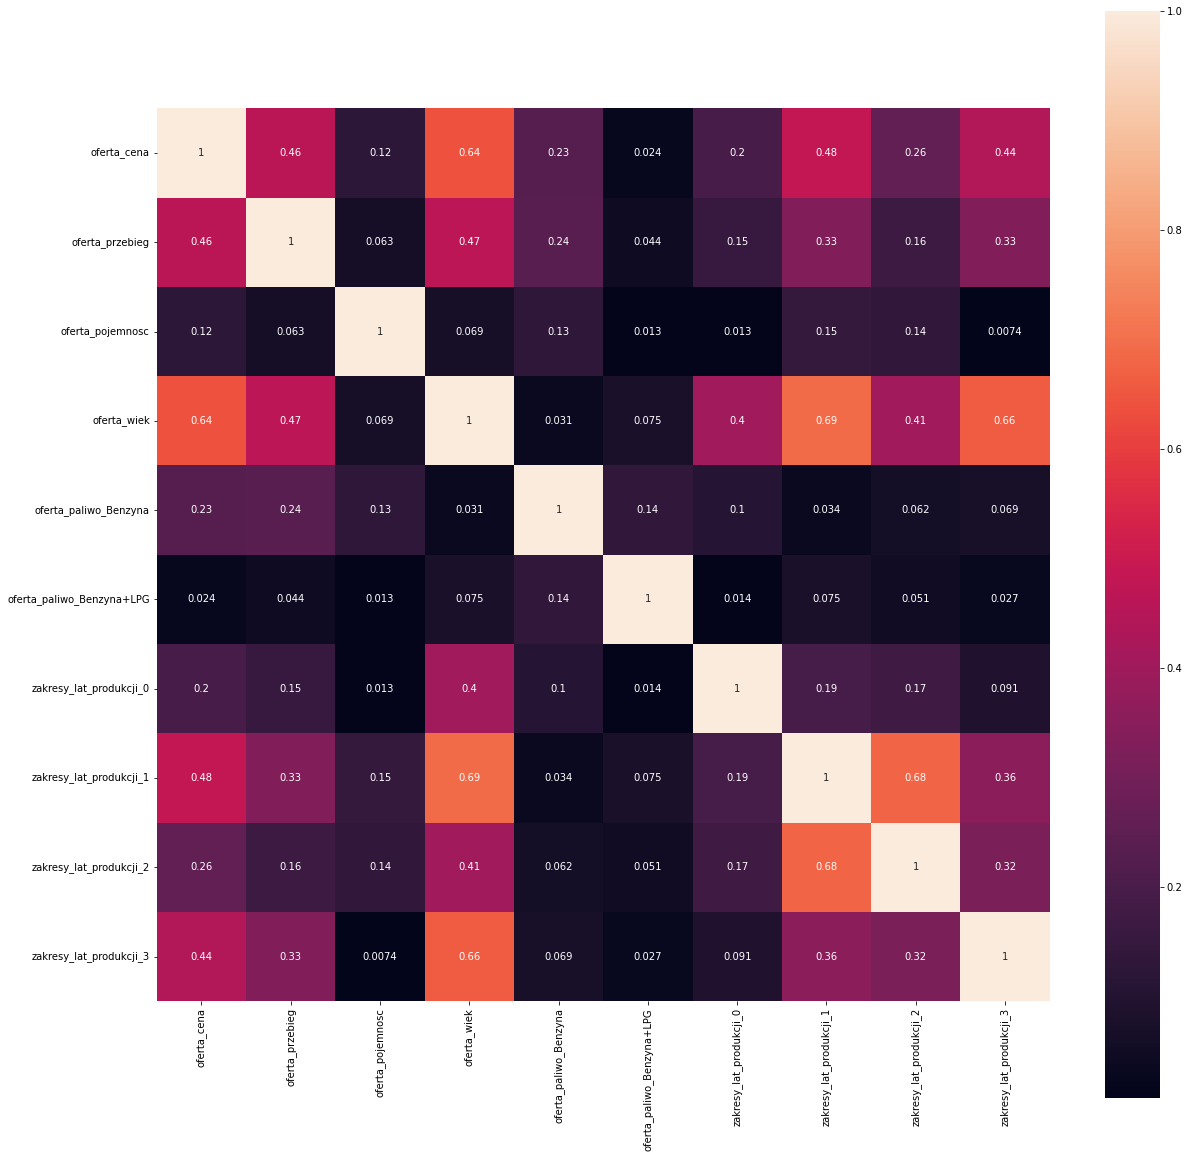

In [ ]:
# ponowne sprawdzenie korelacji między zmiennymi
korelacja_2 = dane_modelowanie_6.corr().abs()
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(korelacja_2, square = True, annot = True);

#### Podział zbioru na uczący i testowy

In [ ]:
from sklearn import model_selection

# tworzenie zbiorów
X = dane_modelowanie_6.drop(columns = ["oferta_cena"])
y = dane_modelowanie_6["oferta_cena"]

# tworzenie zbiorów uczący i testowy
X_uczacy, X_testowy, y_uczacy, y_testowy = model_selection.train_test_split(X, 
                                                                            y.values, 
                                                                            test_size = .2, 
                                                                            random_state = 2020)

In [ ]:
X_uczacy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188 entries, 145 to 100
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   oferta_przebieg            188 non-null    int64
 1   oferta_pojemnosc           188 non-null    int64
 2   oferta_wiek                188 non-null    int64
 3   oferta_paliwo_Benzyna      188 non-null    uint8
 4   oferta_paliwo_Benzyna+LPG  188 non-null    uint8
 5   zakresy_lat_produkcji_0    188 non-null    uint8
 6   zakresy_lat_produkcji_1    188 non-null    uint8
 7   zakresy_lat_produkcji_2    188 non-null    uint8
 8   zakresy_lat_produkcji_3    188 non-null    uint8
dtypes: int64(3), uint8(6)
memory usage: 7.0 KB


In [ ]:
X_testowy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47 entries, 191 to 110
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   oferta_przebieg            47 non-null     int64
 1   oferta_pojemnosc           47 non-null     int64
 2   oferta_wiek                47 non-null     int64
 3   oferta_paliwo_Benzyna      47 non-null     uint8
 4   oferta_paliwo_Benzyna+LPG  47 non-null     uint8
 5   zakresy_lat_produkcji_0    47 non-null     uint8
 6   zakresy_lat_produkcji_1    47 non-null     uint8
 7   zakresy_lat_produkcji_2    47 non-null     uint8
 8   zakresy_lat_produkcji_3    47 non-null     uint8
dtypes: int64(3), uint8(6)
memory usage: 1.7 KB


In [ ]:
print(y_uczacy)

[78900 52900 68500 47700 49700 57000 49900 57900 47900 44900 53000 53900
 34500 94000 76900 51000 54900 68200 51000 58000 46700 49900 68500 71500
 68500 62900 57000 48900 52000 53600 53900 69200 47999 55000 47900 66600
 49900 45500 50900 63000 45800 36200 45400 56000 57000 46900 37900 59700
 53900 49500 73900 41000 55500 56999 63000 47000 57900 49800 50900 72900
 64800 72150 46900 53800 37900 67000 68000 44500 41300 51999 53900 53999
 49900 63900 49800 48500 75400 42900 61500 69000 62000 52900 53999 71900
 64200 49999 69900 47900 51999 52000 44900 71450 44500 45700 34000 37900
 65800 55999 56900 49500 57900 56900 53900 57900 66900 72000 43600 50900
 57000 54000 42900 49900 70900 49900 60000 56900 65900 55900 63900 50900
 69900 49900 51800 39900 62900 62000 67500 71000 46600 75891 53500 46900
 54900 65900 57000 51900 52900 43900 45900 60000 54900 61999 46500 79900
 66900 59500 53999 49000 43800 62000 49900 44900 53000 54900 71900 49900
 43900 49900 48900 35900 61900 45700 59900 69900 67

In [ ]:
print(y_testowy)

[47500 55900 59900 62222 49900 58900 47900 47900 49900 51900 61500 50800
 58000 61900 66900 75000 68500 74900 42444 45300 58900 55500 73000 61300
 72900 68900 63900 73900 46900 67800 69700 49500 57000 54800 55999 41000
 47900 54900 49900 42900 64500 55700 54000 39900 43900 59900 55000]


#### Standaryzacja zmiennych objaśniających

In [ ]:
from sklearn import preprocessing

# standaryzowanie cech objaśniających
standaryzacja = preprocessing.StandardScaler()
fit_stand = standaryzacja.fit(X_uczacy)
X_uczacy_stand = fit_stand.transform(X_uczacy)
X_testowy_stand = fit_stand.transform(X_testowy)